In [1]:
import sys
import sklearn
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
print('python version', sys.version_info)
print('sklean version', sklearn.__version__)
print('tensorflow version', tf.__version__)

python version sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
sklean version 1.0.1
tensorflow version 2.7.0


In [6]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [7]:
PROJECT_ROOT_DIR = 'data'
CHAPTER_ID = 'ann'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

In [8]:
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + '.' + fig_extension)
    print('saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Perceptrons

In [16]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
iris = load_iris()
X = iris.data[:, (2, 3)] #petal length, petal width
y = (iris.target == 0).astype(np.int)
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])
print(y_pred)

[1]


In [18]:
print(per_clf.coef_)
print(per_clf.intercept_)

[[-1.4 -2.2]]
[4.]


(0.0, 5.0, 0.0, 2.0)

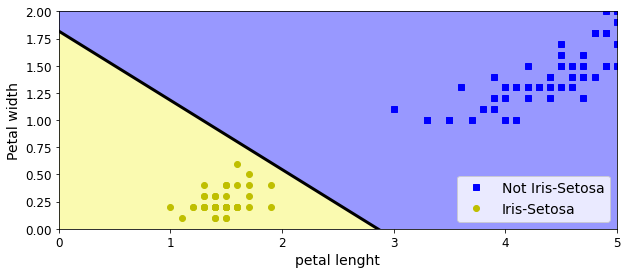

In [57]:
from matplotlib.colors import ListedColormap
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y==1, 0], X[y==1, 1], 'yo', label='Iris-Setosa')

plt.plot([axes[0], axes[1]], [a *axes[0]+b, a*axes[1] + b], 'k-', linewidth=3)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel('petal lenght', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)
#save_fig('perceptron_iris_plot')
#plt.show()

### Activation functions

In [58]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

(-5.0, 5.0, -0.2, 1.2)

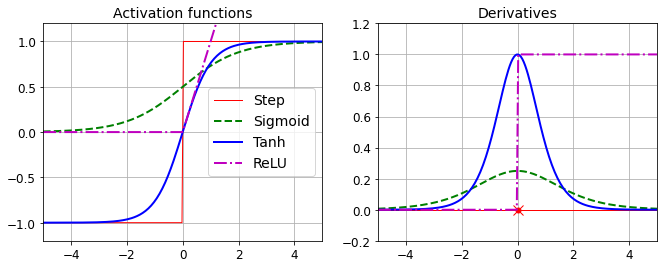

In [75]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='Step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc='center right', fontsize=14)
plt.title('Activation functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', linewidth=1, label='Step')
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, derivative(np.tanh, z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, derivative(relu, z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.title('Derivatives', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig('activation_finctions_plot')
#plt.show()

In [77]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)
def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) -0.5)

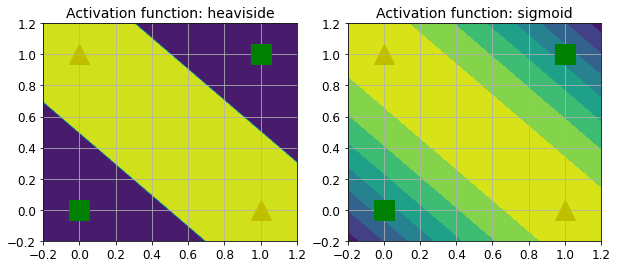

In [87]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)
z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: heaviside', fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: sigmoid', fontsize=14)
plt.grid(True)

### Building an Image Classifier

In [90]:
from tensorflow import keras
tf.__version__, keras.__version__

('2.7.0', '2.7.0')

In [92]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [93]:
print(X_train_full.shape)
print(X_train_full.dtype)

(60000, 28, 28)
uint8


In [94]:
val_size = 5000
X_valid, X_train = X_train_full[:val_size] / 255, X_train_full[val_size:] / 255
y_valid, y_train = y_train_full[:val_size], y_train_full[val_size:]
X_test = X_test / 255

In [95]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

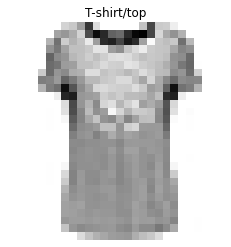

In [104]:
eg_ix = 1
plt.imshow(X_train[eg_ix], cmap='binary')
plt.axis('off')
cat = class_names[y_train[eg_ix]]
plt.title(cat)
plt.show()

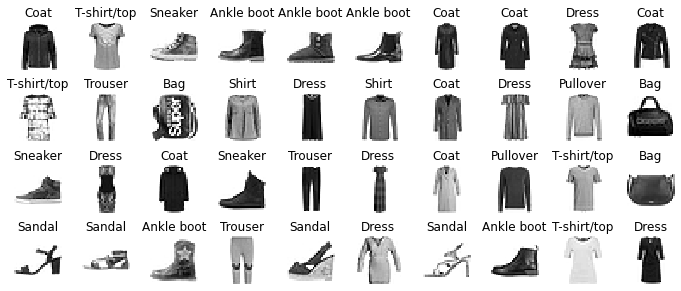

In [107]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [109]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [110]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [111]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [116]:
model.layers

In [117]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [119]:
keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [124]:
hidden1 = model.layers[1]
print(hidden1.name)
weights, biases = hidden1.get_weights()
print(weights.shape, biases.shape)

dense
(784, 300) (300,)


In [125]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

In [126]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
              optimizer=keras.optimizers.SGD(), 
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [127]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

2022-01-19 11:09:44.885145: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-19 11:09:45.011027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
1719/1719 [==============================] - ETA: 0s - loss: 0.7163 - sparse_categorical_accuracy: 0.7616

2022-01-19 11:09:53.486198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 9s 5ms/step - loss: 0.7163 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.5296 - val_sparse_categorical_accuracy: 0.8192
Epoch 2/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4899 - sparse_categorical_accuracy: 0.8294 - val_loss: 0.4412 - val_sparse_categorical_accuracy: 0.8492
Epoch 3/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4430 - sparse_categorical_accuracy: 0.8434 - val_loss: 0.5356 - val_sparse_categorical_accuracy: 0.7984
Epoch 4/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4152 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.3992 - val_sparse_categorical_accuracy: 0.8644
Epoch 5/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3966 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.3818 - val_sparse_categorical_accuracy: 0.8666
Epoch 6/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3779 - sparse_categoric

In [130]:
print('history params:', history.params)
print('epoch:', history.epoch)
print('history keys: ', history.history.keys())

history params: {'verbose': 1, 'epochs': 30, 'steps': 1719}
epoch: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
history keys:  dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


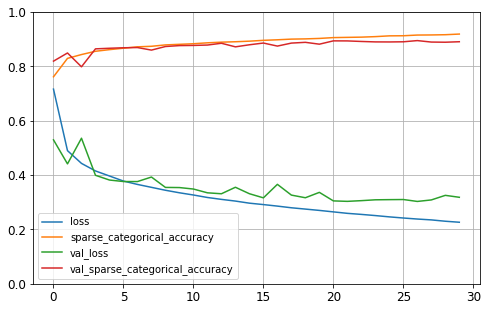

In [132]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig('keras_learning_curves_plot')
plt.show()

In [135]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3451 - sparse_categorical_accuracy: 0.8781


[0.3450942933559418, 0.8781000375747681]

In [138]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [139]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [144]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [145]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

saving figure fashion_mnist_images_plot


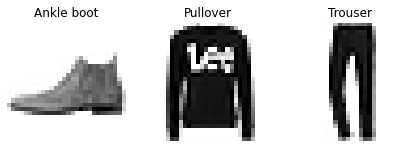

In [147]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index+1)
    plt.imshow(image, cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

### Regression MLP

In [151]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((11610, 8), (3870, 8), (5160, 8), (11610,), (3870,), (5160,))

In [152]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [153]:
np.random.seed(42)
tf.random.set_seed(42)

In [156]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
 38/363 [==>...........................] - ETA: 0s - loss: 5.0192

2022-01-19 12:12:15.813049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


351/363 [============================>.] - ETA: 0s - loss: 2.1090

2022-01-19 12:12:16.907183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 1s 4ms/step - loss: 2.0702 - val_loss: 1.4423
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7619 - val_loss: 0.7324
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6571 - val_loss: 0.6206
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6087 - val_loss: 0.5897
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5723 - val_loss: 0.5546
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5418 - val_loss: 0.5428
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5191 - val_loss: 0.5195
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5004 - val_loss: 0.5086
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4854 - val_loss: 0.5102
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4734 - val_loss: 0.5099
Epoch 11/2

2022-01-19 12:12:40.162114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


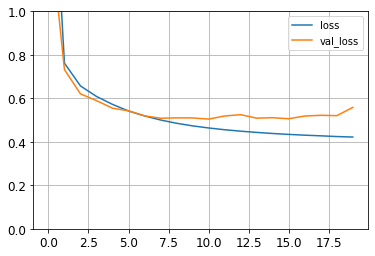

In [159]:
#plt.plot(pd.DataFrame(history.history))
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [160]:
y_pred

array([[0.6662812],
       [1.772532 ],
       [3.2530885]], dtype=float32)

### Functional API

In [161]:
np.random.seed(42)
tf.random.set_seed(42)

In [163]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [164]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 30)           930         ['dense_8[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_9[0][0]']            

In [165]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
 15/363 [>.............................] - ETA: 1s - loss: 5.9146  

2022-01-19 15:29:07.309561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


355/363 [============================>.] - ETA: 0s - loss: 2.2074

2022-01-19 15:29:08.628418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 4ms/step - loss: 2.1785 - val_loss: 0.8649
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7267 - val_loss: 0.7060
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6368 - val_loss: 0.6241
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5991 - val_loss: 0.5717
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5719 - val_loss: 0.5447
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5490 - val_loss: 0.5228
Epoch 7/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5311 - val_loss: 0.5062
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5161 - val_loss: 0.4915
Epoch 9/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5028 - val_loss: 0.4762
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4919 - val_loss: 0.4637
Epoch 11/2

2022-01-19 15:29:35.721850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


##### send different subsets of input features through the wide or deep paths

In [166]:
np.random.seed(42)
tf.random.set_seed(42)

In [168]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [171]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A,  X_test_B  = X_test[:, :5],  X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
 31/363 [=>............................] - ETA: 1s - loss: 0.4831

2022-01-19 15:43:55.267239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - ETA: 0s - loss: 0.4134

2022-01-19 15:43:56.528241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 4ms/step - loss: 0.4134 - val_loss: 0.4025
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4124 - val_loss: 0.4084
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4107 - val_loss: 0.4048
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4087 - val_loss: 0.4106
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4084 - val_loss: 0.4012
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4064 - val_loss: 0.4061
Epoch 7/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4060 - val_loss: 0.4018
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4047 - val_loss: 0.3976
Epoch 9/20
363/363 [==============================] - 2s 4ms/step - loss: 0.4034 - val_loss: 0.3990
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4026 - val_loss: 0.3980
Epoch 11/2

2022-01-19 15:44:23.702246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


##### Adding an auxilary output for regularization

In [172]:
np.random.seed(42)
tf.random.set_seed(42)

In [174]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 dense_17 (Dense)               (None, 30)           210         ['deep_input[0][0]']             
                                                                                                  
 wide_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 30)           930         ['dense_17[0][0]']               
                                                                                            

In [177]:
model.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
 10/363 [..............................] - ETA: 2s - loss: 6.9497 - main_output_loss: 6.9476 - aux_output_loss: 6.9681  

2022-01-19 16:13:14.623377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


358/363 [============================>.] - ETA: 0s - loss: 3.1180 - main_output_loss: 2.9117 - aux_output_loss: 4.9742

2022-01-19 16:13:16.535732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 6ms/step - loss: 3.0962 - main_output_loss: 2.8886 - aux_output_loss: 4.9645 - val_loss: 1.9726 - val_main_output_loss: 1.4054 - val_aux_output_loss: 7.0773
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 1.1751 - main_output_loss: 0.9682 - aux_output_loss: 3.0377 - val_loss: 1.0235 - val_main_output_loss: 0.7764 - val_aux_output_loss: 3.2475
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.8796 - main_output_loss: 0.7355 - aux_output_loss: 2.1773 - val_loss: 0.8150 - val_main_output_loss: 0.6859 - val_aux_output_loss: 1.9768
Epoch 4/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7677 - main_output_loss: 0.6555 - aux_output_loss: 1.7776 - val_loss: 0.7010 - val_main_output_loss: 0.5970 - val_aux_output_loss: 1.6369
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7048 - main_output_loss: 0.6073 - aux_output_loss: 1.5827 - val_loss: 0.6591 - 

In [178]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 1s 4ms/step - loss: 0.4834 - main_output_loss: 0.4226 - aux_output_loss: 1.0309


In [182]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
y_pred_main, y_test[:3]

(array([[0.5030822],
        [1.9924799],
        [3.2497544]], dtype=float32),
 array([0.477  , 0.458  , 5.00001]))

### The Subclassing API

In [187]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
model = WideAndDeepModel(30, activation='relu')
#model.summary()

In [192]:
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
#model.summary()

In [193]:
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10, 
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

Epoch 1/10
 12/363 [..............................] - ETA: 1s - loss: 6.8688 - output_1_loss: 7.0605 - output_2_loss: 5.1436  

2022-01-19 16:29:38.024073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


358/363 [============================>.] - ETA: 0s - loss: 3.1589 - output_1_loss: 3.0468 - output_2_loss: 4.1675

2022-01-19 16:29:39.995252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 3s 6ms/step - loss: 3.1375 - output_1_loss: 3.0237 - output_2_loss: 4.1622 - val_loss: 2.4812 - val_output_1_loss: 2.3094 - val_output_2_loss: 4.0271
Epoch 2/10
363/363 [==============================] - 2s 6ms/step - loss: 1.1389 - output_1_loss: 0.9602 - output_2_loss: 2.7475 - val_loss: 1.0575 - val_output_1_loss: 0.7784 - val_output_2_loss: 3.5700
Epoch 3/10
363/363 [==============================] - 2s 6ms/step - loss: 0.8710 - output_1_loss: 0.7385 - output_2_loss: 2.0639 - val_loss: 0.9390 - val_output_1_loss: 0.6703 - val_output_2_loss: 3.3574
Epoch 4/10
363/363 [==============================] - 2s 6ms/step - loss: 0.7791 - output_1_loss: 0.6723 - output_2_loss: 1.7408 - val_loss: 0.8770 - val_output_1_loss: 0.6221 - val_output_2_loss: 3.1712
Epoch 5/10
363/363 [==============================] - 2s 6ms/step - loss: 0.7289 - output_1_loss: 0.6350 - output_2_loss: 1.5737 - val_loss: 0.8281 - val_output_1_loss: 0.5910 - val_output_2_loss

In [195]:
model.summary()

Model: "wide_and_deep_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            multiple                  210       
                                                                 
 dense_32 (Dense)            multiple                  930       
                                                                 
 dense_33 (Dense)            multiple                  36        
                                                                 
 dense_34 (Dense)            multiple                  31        
                                                                 
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


### Saving and Restoring

In [194]:
np.random.seed(42)
tf.random.set_seed(42)

In [196]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 30)                270       
                                                                 
 dense_36 (Dense)            (None, 30)                930       
                                                                 
 dense_37 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


In [197]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
 34/363 [=>............................] - ETA: 1s - loss: 5.5975 

2022-01-19 16:39:08.396183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


359/363 [============================>.] - ETA: 0s - loss: 2.5023

2022-01-19 16:39:09.580171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 4ms/step - loss: 2.4880 - val_loss: 1.2107
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.8482 - val_loss: 0.9154
Epoch 3/10
363/363 [==============================] - 2s 4ms/step - loss: 0.6460 - val_loss: 0.6363
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5905 - val_loss: 0.5427
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5565 - val_loss: 0.5121
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5279 - val_loss: 0.4895
Epoch 7/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5060 - val_loss: 0.4798
Epoch 8/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4875 - val_loss: 0.4539
Epoch 9/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4714 - val_loss: 0.4366
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4450


In [199]:
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, 'models', CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)
save_path = os.path.join(MODEL_PATH, 'my_keras_model.h5')
model.save(save_path)

In [200]:
model_loaded = keras.models.load_model(save_path)
model_loaded.predict(X_new)

2022-01-19 16:45:24.131902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.66939443],
       [1.6020007 ],
       [3.257522  ]], dtype=float32)

In [201]:
weights_path = os.path.join(MODEL_PATH, 'my_keras_weights.ckpt')
model.save_weights(weights_path)

In [203]:
model_new = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])
model_new.load_weights(weights_path)
model_new.predict(X_new)

2022-01-19 16:48:29.554499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.66939443],
       [1.6020007 ],
       [3.257522  ]], dtype=float32)

### Using Callbacks during Training

In [206]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [207]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [210]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_path = os.path.join(MODEL_PATH, 'my_keras_model_checkpoint.h5')
checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[checkpoint_cb])
mse = model.evaluate(X_test, y_test)

Epoch 1/10
 33/363 [=>............................] - ETA: 1s - loss: 0.5299

2022-01-19 16:59:18.924959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


358/363 [============================>.] - ETA: 0s - loss: 0.4474

2022-01-19 16:59:20.172760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 4ms/step - loss: 0.4478 - val_loss: 0.4181
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4388 - val_loss: 0.4127
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4310 - val_loss: 0.4081
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4236 - val_loss: 0.4057
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4184 - val_loss: 0.3956
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4126 - val_loss: 0.4099
Epoch 7/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4086 - val_loss: 0.3874
Epoch 8/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4043 - val_loss: 0.3834
Epoch 9/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4006 - val_loss: 0.3857
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.3921


In [211]:
model_best = keras.models.load_model(checkpoint_path)
mse_best = model_best.evaluate(X_test, y_test)
print(mse, mse_best)

 65/162 [===========>..................] - ETA: 0s - loss: 0.4163

2022-01-19 16:59:46.553298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 0s 2ms/step - loss: 0.3979
0.39205971360206604 0.39786091446876526


In [212]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
 34/363 [=>............................] - ETA: 1s - loss: 0.4481

2022-01-19 17:03:02.845942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - ETA: 0s - loss: 0.3944

2022-01-19 17:03:04.128177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 4ms/step - loss: 0.3944 - val_loss: 0.3801
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3917 - val_loss: 0.4086
Epoch 3/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3892 - val_loss: 0.3925
Epoch 4/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3866 - val_loss: 0.3757
Epoch 5/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3847 - val_loss: 0.3686
Epoch 6/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3822 - val_loss: 0.3935
Epoch 7/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3807 - val_loss: 0.3661
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3787 - val_loss: 0.3622
Epoch 9/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3768 - val_loss: 0.3660
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3750 - val_loss: 0.3842
E

<AxesSubplot:>

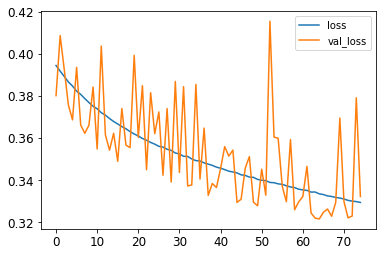

In [213]:
pd.DataFrame(history.history).plot()

In [214]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('\nval/train: {:.2f}'.format(logs['val_loss'] / logs['loss']))

In [218]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=[X_valid, y_valid],
                    callbacks=[val_train_ratio_cb])

Epoch 1/10
347/363 [===========================>..] - ETA: 0s - loss: 0.3300
val/train: 1.03
363/363 [==============================] - 1s 4ms/step - loss: 0.3330 - val_loss: 0.3426
Epoch 2/10
355/363 [============================>.] - ETA: 0s - loss: 0.3329
val/train: 1.03
363/363 [==============================] - 1s 4ms/step - loss: 0.3325 - val_loss: 0.3423
Epoch 3/10
349/363 [===========================>..] - ETA: 0s - loss: 0.3341
val/train: 1.02
363/363 [==============================] - 1s 4ms/step - loss: 0.3320 - val_loss: 0.3389
Epoch 4/10
353/363 [============================>.] - ETA: 0s - loss: 0.3321
val/train: 0.99
363/363 [==============================] - 1s 4ms/step - loss: 0.3321 - val_loss: 0.3291
Epoch 5/10
351/363 [============================>.] - ETA: 0s - loss: 0.3294
val/train: 1.02
363/363 [==============================] - 1s 4ms/step - loss: 0.3315 - val_loss: 0.3365
Epoch 6/10
353/363 [============================>.] - ETA: 0s - loss: 0.3305
val/train: 0.

### TensorBoard

In [219]:
#MODEL_PATH
root_logdir = os.path.join(MODEL_PATH, 'my_logs')
print(root_logdir)

data/models/ann/my_logs


In [220]:
def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir

'data/models/ann/my_logs/run_2022_01_20-19_21_03'

In [221]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [223]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [225]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
 33/363 [=>............................] - ETA: 1s - loss: 5.6558

2022-01-20 19:25:31.968038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/363 [============================>.] - ETA: 0s - loss: 2.5305

2022-01-20 19:25:33.200837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 4ms/step - loss: 2.4880 - val_loss: 1.2107
Epoch 2/30
363/363 [==============================] - 1s 4ms/step - loss: 0.8482 - val_loss: 0.9154
Epoch 3/30
363/363 [==============================] - 1s 4ms/step - loss: 0.6460 - val_loss: 0.6363
Epoch 4/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5905 - val_loss: 0.5427
Epoch 5/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5565 - val_loss: 0.5121
Epoch 6/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5279 - val_loss: 0.4895
Epoch 7/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5060 - val_loss: 0.4798
Epoch 8/30
363/363 [==============================] - 1s 4ms/step - loss: 0.4875 - val_loss: 0.4539
Epoch 9/30
363/363 [==============================] - 1s 4ms/step - loss: 0.4714 - val_loss: 0.4366
Epoch 10/30
363/363 [==============================] - 1s 4ms/step - loss: 0.4586 - val_loss: 0.4252
Epoch 11/3

In [226]:
%load_ext tensorboard
%tensorboard --logdir=./data/models/ann/my_logs

In [227]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



### Hyperparameter Tuning

In [229]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [230]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [231]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
keras_reg.fit(X_train, y_train, epochs=100, 
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
  1/363 [..............................] - ETA: 44s - loss: 8.8405

/var/folders/fv/z57dkw050td4yrrln0jg6w200000gn/T/ipykernel_40936/1401762012.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
2022-01-20 19:38:41.299572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/363 [============================>.] - ETA: 0s - loss: 1.3814

2022-01-20 19:38:42.401576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 1s 4ms/step - loss: 1.3620 - val_loss: 11.0255
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.8115 - val_loss: 20.9611
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.7416 - val_loss: 22.1484
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.6430 - val_loss: 4.8793
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4901 - val_loss: 0.4233
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4447 - val_loss: 0.4230
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4355 - val_loss: 0.4086
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4288 - val_loss: 0.4041
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4234 - val_loss: 0.4063
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4190 - val_loss: 0.410

In [232]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3513


In [246]:
#keras_reg.evaluate(X_test, y_test)
mse_test

-0.3512786626815796

In [234]:
y_pred = keras_reg.predict(X_new)

2022-01-20 19:42:32.112003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [235]:
np.random.seed(42)
tf.random.set_seed(42)

In [237]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100).tolist(),
    'learning_rate': reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
 27/242 [==>...........................] - ETA: 0s - loss: 2.4161

2022-01-20 19:49:56.055661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 1.0010

2022-01-20 19:49:56.991024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 1.0010 - val_loss: 3.6394
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5488 - val_loss: 1.8038
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4574 - val_loss: 0.4755
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4104 - val_loss: 0.3816
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3872 - val_loss: 0.3737
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3740 - val_loss: 0.3827
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3648 - val_loss: 0.3686
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3560 - val_loss: 0.4172
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3518 - val_loss: 0.3716
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3469 - val_loss: 0.3911
E

2022-01-20 19:50:40.666366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/242 [============================>.] - ETA: 0s - loss: 1.0329

2022-01-20 19:50:41.565929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 1.0197 - val_loss: 0.5565
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5140 - val_loss: 0.4712
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4463 - val_loss: 0.4036
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4123 - val_loss: 0.3804
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3929 - val_loss: 0.3971
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3814 - val_loss: 0.4762
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3744 - val_loss: 0.5964
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3687 - val_loss: 0.6963
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3622 - val_loss: 0.8040
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3590 - val_loss: 0.7870
E

2022-01-20 19:50:55.623132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


239/242 [============================>.] - ETA: 0s - loss: 0.8327

2022-01-20 19:50:56.510888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.8294 - val_loss: 0.5185
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4936 - val_loss: 0.5441
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4467 - val_loss: 0.3970
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4144 - val_loss: 0.5582
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4069 - val_loss: 0.5148
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3889 - val_loss: 0.4977
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3825 - val_loss: 0.3617
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3749 - val_loss: 0.3679
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3696 - val_loss: 0.3768
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3686 - val_loss: 0.3963
E

2022-01-20 19:51:13.776723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/242 [============================>.] - ETA: 0s - loss: 1.0366

2022-01-20 19:51:14.578025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 1.0331 - val_loss: 55.8603
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 1.2441 - val_loss: 43.8107
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8878 - val_loss: 64.7147
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5365 - val_loss: 22.7757
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5984 - val_loss: 127.0834
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 1.5866 - val_loss: 0.3755
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3822 - val_loss: 0.3567
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3691 - val_loss: 0.3473
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3636 - val_loss: 0.3503
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3591 - val_loss: 0.

2022-01-20 19:52:06.369311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 0.8700

2022-01-20 19:52:07.120874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 0.8700 - val_loss: 0.6922
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4830 - val_loss: 0.9069
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4285 - val_loss: 0.4384
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4099 - val_loss: 0.3777
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3967 - val_loss: 0.3849
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3876 - val_loss: 0.6433
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3826 - val_loss: 0.9372
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3765 - val_loss: 0.9187
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3725 - val_loss: 1.0360
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3703 - val_loss: 0.6159
E

2022-01-20 19:52:19.259242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/242 [============================>.] - ETA: 0s - loss: 0.8360

2022-01-20 19:52:20.035285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 0.8270 - val_loss: 26.6777
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6478 - val_loss: 26.9211
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6049 - val_loss: 2.0149
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4473 - val_loss: 0.3936
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4204 - val_loss: 0.3951
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4051 - val_loss: 0.4034
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4035 - val_loss: 0.4006
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3963 - val_loss: 0.4033
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3906 - val_loss: 0.4169
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3886 - val_loss: 0.3960

2022-01-20 19:53:06.024179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


236/242 [============================>.] - ETA: 0s - loss: 3.5805

2022-01-20 19:53:06.870264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 3.5375 - val_loss: 2.0480
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 1.5565 - val_loss: 1.5943
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 1.0968 - val_loss: 1.2130
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.9203 - val_loss: 0.9376
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8246 - val_loss: 0.8095
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7669 - val_loss: 0.7586
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7292 - val_loss: 0.7403
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7029 - val_loss: 0.7134
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6823 - val_loss: 0.6804
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6646 - val_loss: 0.6678
E

242/242 [==============================] - 1s 4ms/step - loss: 0.3918 - val_loss: 0.3968
Epoch 82/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3911 - val_loss: 0.3982
Epoch 83/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3904 - val_loss: 0.3918
Epoch 84/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3897 - val_loss: 0.3954
Epoch 85/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3890 - val_loss: 0.3899
Epoch 86/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3882 - val_loss: 0.3974
Epoch 87/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3878 - val_loss: 0.3875
Epoch 88/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3871 - val_loss: 0.3847
Epoch 89/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3864 - val_loss: 0.3861
Epoch 90/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3857 - val_loss: 

2022-01-20 19:54:45.149176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


234/242 [============================>.] - ETA: 0s - loss: 3.7568

2022-01-20 19:54:46.001669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 3.7195 - val_loss: 24.2800
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 1.8551 - val_loss: 32.7220
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 1.3311 - val_loss: 33.3857
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 1.1001 - val_loss: 30.8482
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.9596 - val_loss: 27.4234
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8682 - val_loss: 24.2199
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8073 - val_loss: 21.4198
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7649 - val_loss: 18.8485
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7333 - val_loss: 16.6520
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7081 - val_loss:

2022-01-20 19:55:51.653042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/242 [============================>.] - ETA: 0s - loss: 3.8158

2022-01-20 19:55:52.513469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 3.7968 - val_loss: 4.5333
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 1.9628 - val_loss: 4.3244
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 1.2464 - val_loss: 2.8533
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.9466 - val_loss: 1.7945
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8146 - val_loss: 1.1273
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7496 - val_loss: 0.8463
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7125 - val_loss: 0.7378
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6883 - val_loss: 0.6742
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6705 - val_loss: 0.6524
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6555 - val_loss: 0.6361
E

242/242 [==============================] - 1s 4ms/step - loss: 0.3927 - val_loss: 0.4052
Epoch 82/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3920 - val_loss: 0.4043
Epoch 83/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3913 - val_loss: 0.4041
Epoch 84/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3907 - val_loss: 0.4042
Epoch 85/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3900 - val_loss: 0.3988
Epoch 86/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3894 - val_loss: 0.4011
Epoch 87/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3887 - val_loss: 0.4050
Epoch 88/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3881 - val_loss: 0.4031
Epoch 89/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3875 - val_loss: 0.4049
Epoch 90/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3869 - val_loss: 

2022-01-20 19:57:31.043486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


238/242 [============================>.] - ETA: 0s - loss: 1.0846

2022-01-20 19:57:31.970744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 1.0751 - val_loss: 1.2503
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5835 - val_loss: 6.2887
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5266 - val_loss: 1.5042
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4400 - val_loss: 0.3861
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3969 - val_loss: 0.3688
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3782 - val_loss: 0.3851
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3668 - val_loss: 0.3844
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3574 - val_loss: 0.3990
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3514 - val_loss: 0.3879
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3470 - val_loss: 0.3900
E

2022-01-20 19:58:36.563295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


236/242 [============================>.] - ETA: 0s - loss: 0.8635

2022-01-20 19:58:37.502702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.8546 - val_loss: 1.0071
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5141 - val_loss: 0.4307
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4296 - val_loss: 0.3915
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3926 - val_loss: 0.4138
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3734 - val_loss: 0.4998
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3629 - val_loss: 0.6564
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3554 - val_loss: 0.8090
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3502 - val_loss: 0.7917
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3437 - val_loss: 0.7745
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3404 - val_loss: 0.5282
E

2022-01-20 19:58:50.845230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/242 [============================>.] - ETA: 0s - loss: 0.8956

2022-01-20 19:58:51.743452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.8863 - val_loss: 0.5218
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4936 - val_loss: 0.6904
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4406 - val_loss: 0.8094
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4177 - val_loss: 0.8780
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4053 - val_loss: 0.3830
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3844 - val_loss: 0.4113
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3768 - val_loss: 0.3740
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3670 - val_loss: 0.3874
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3638 - val_loss: 0.4113
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3565 - val_loss: 0.3333
E

2022-01-20 19:59:29.482149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 1.3198

2022-01-20 19:59:30.418727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 1.3198 - val_loss: 3.0934
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6258 - val_loss: 0.9688
Epoch 3/100
242/242 [==============================] - 1s 5ms/step - loss: 0.5164 - val_loss: 0.4677
Epoch 4/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4609 - val_loss: 0.4259
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4284 - val_loss: 0.4036
Epoch 6/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4057 - val_loss: 0.4233
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3901 - val_loss: 0.3918
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3792 - val_loss: 0.4350
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3718 - val_loss: 0.4049
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3655 - val_loss: 0.4102
E

2022-01-20 19:59:53.745432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


241/242 [============================>.] - ETA: 0s - loss: 1.3142

2022-01-20 19:59:54.685020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 1.3125 - val_loss: 2.5387
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6487 - val_loss: 0.8111
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5540 - val_loss: 0.4866
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4854 - val_loss: 0.6615
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4401 - val_loss: 0.7571
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4145 - val_loss: 0.6246
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3990 - val_loss: 0.4881
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3879 - val_loss: 0.3827
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3782 - val_loss: 0.3563
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3712 - val_loss: 0.3693
E

2022-01-20 20:00:14.715462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


239/242 [============================>.] - ETA: 0s - loss: 1.3449

2022-01-20 20:00:15.678221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 1.3373 - val_loss: 9.0937
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6672 - val_loss: 3.4451
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5282 - val_loss: 0.4496
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4571 - val_loss: 0.4228
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4280 - val_loss: 0.3996
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4092 - val_loss: 0.4069
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3965 - val_loss: 0.3738
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3868 - val_loss: 0.3701
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3787 - val_loss: 0.4107
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3745 - val_loss: 0.3480
E

2022-01-20 20:00:49.535753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


231/242 [===========================>..] - ETA: 0s - loss: 0.9321

2022-01-20 20:00:50.278978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 0.9132 - val_loss: 31.3617
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6929 - val_loss: 1.1775
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4115 - val_loss: 1.7509
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3822 - val_loss: 0.3567
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3674 - val_loss: 0.3461
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3628 - val_loss: 0.3442
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3544 - val_loss: 0.3401
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3494 - val_loss: 0.3344
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3462 - val_loss: 0.3565
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3448 - val_loss: 0.3250


2022-01-20 20:01:36.153082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


229/242 [===========================>..] - ETA: 0s - loss: 0.6528

2022-01-20 20:01:36.913250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 0.6470 - val_loss: 0.4634
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4469 - val_loss: 0.8308
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4065 - val_loss: 1.6997
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4200 - val_loss: 0.4856
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3865 - val_loss: 0.4108
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3810 - val_loss: 0.5514
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3949 - val_loss: 0.7042
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3736 - val_loss: 0.7050
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3737 - val_loss: 0.7685
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3701 - val_loss: 0.4369
E

2022-01-20 20:02:12.277709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


233/242 [===========================>..] - ETA: 0s - loss: 0.8344

2022-01-20 20:02:13.017889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 0.8214 - val_loss: 84.8358
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4429 - val_loss: 4.8338
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4973 - val_loss: 68.7372
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 13.7694 - val_loss: 1.8237
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4759 - val_loss: 55.4132
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4852 - val_loss: 4.9385
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4154 - val_loss: 2.0940
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4360 - val_loss: 0.3687
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4755 - val_loss: 0.3671
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4226 - val_loss: 0.35

2022-01-20 20:02:43.488808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


239/242 [============================>.] - ETA: 0s - loss: 0.8039

2022-01-20 20:02:44.417170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.7998 - val_loss: 17.4663
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6498 - val_loss: 1.6428
Epoch 3/100
242/242 [==============================] - 13s 54ms/step - loss: 0.4382 - val_loss: 4.1283
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4117 - val_loss: 2.0345
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4163 - val_loss: 1.3003
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3956 - val_loss: 4.2593
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4236 - val_loss: 2.7652
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3980 - val_loss: 0.3558
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3620 - val_loss: 0.3525
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3546 - val_loss: 0.330

2022-01-20 20:03:34.378034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


239/242 [============================>.] - ETA: 0s - loss: 0.6952

2022-01-20 20:03:35.304985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.6915 - val_loss: 0.3946
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4077 - val_loss: 0.6473
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3828 - val_loss: 0.7864
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3716 - val_loss: 0.5299
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3614 - val_loss: 0.4565
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3545 - val_loss: 0.5390
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3510 - val_loss: 0.6751
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3458 - val_loss: 0.7314
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3401 - val_loss: 0.7883
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3368 - val_loss: 0.5033
E

2022-01-20 20:03:46.227572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


237/242 [============================>.] - ETA: 0s - loss: 0.7335

2022-01-20 20:03:47.145740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.7281 - val_loss: 0.4547
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4461 - val_loss: 0.3746
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4063 - val_loss: 0.6101
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3876 - val_loss: 0.4201
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3729 - val_loss: 0.3381
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3654 - val_loss: 0.4007
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3589 - val_loss: 0.3328
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3514 - val_loss: 0.3599
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3446 - val_loss: 0.3378
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3417 - val_loss: 0.3234
E

2022-01-20 20:04:38.062024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 0.6285

2022-01-20 20:04:39.010157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.6285 - val_loss: 3.4253
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4151 - val_loss: 6.1387
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5307 - val_loss: 1.2277
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3719 - val_loss: 0.7606
Epoch 5/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3568 - val_loss: 0.7370
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3533 - val_loss: 3.4440
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3930 - val_loss: 0.9138
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3433 - val_loss: 1.5031
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3422 - val_loss: 0.4600
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3249 - val_loss: 0.3165
E

2022-01-20 20:05:35.124051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 0.5800

2022-01-20 20:05:36.092354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.5800 - val_loss: 0.7082
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3870 - val_loss: 2.4653
Epoch 3/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3611 - val_loss: 3.0727
Epoch 4/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3491 - val_loss: 0.8044
Epoch 5/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3367 - val_loss: 0.6111
Epoch 6/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3257 - val_loss: 0.7898
Epoch 7/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3181 - val_loss: 0.9806
Epoch 8/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3166 - val_loss: 0.7928
Epoch 9/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3087 - val_loss: 0.4029
Epoch 10/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3044 - val_loss: 0.3733
E

2022-01-20 20:06:02.708313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


233/242 [===========================>..] - ETA: 0s - loss: 0.6287

2022-01-20 20:06:03.700430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.6204 - val_loss: 0.3697
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4022 - val_loss: 0.3910
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3845 - val_loss: 2.8341
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4104 - val_loss: 2.3464
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3858 - val_loss: 3.0742
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4017 - val_loss: 0.4750
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3780 - val_loss: 8.8260
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3651 - val_loss: 0.9737
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3422 - val_loss: 0.4039
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3322 - val_loss: 0.3215
E

2022-01-20 20:06:44.494078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


231/242 [===========================>..] - ETA: 0s - loss: 1.2339

2022-01-20 20:06:45.393351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 1.2057 - val_loss: 1.3270
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5900 - val_loss: 7.2029
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5524 - val_loss: 5.0960
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5081 - val_loss: 0.6980
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4314 - val_loss: 0.4419
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4110 - val_loss: 0.4361
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3999 - val_loss: 0.3987
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3910 - val_loss: 0.4170
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3854 - val_loss: 0.4159
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3809 - val_loss: 0.4084
E

2022-01-20 20:07:44.768095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/242 [============================>.] - ETA: 0s - loss: 1.0239

2022-01-20 20:07:45.724836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 1.0094 - val_loss: 4.6077
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5193 - val_loss: 2.1123
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4563 - val_loss: 1.3073
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4300 - val_loss: 1.0634
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4154 - val_loss: 0.9663
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4065 - val_loss: 1.1071
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4005 - val_loss: 1.1361
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3940 - val_loss: 1.2309
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3880 - val_loss: 1.3413
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3850 - val_loss: 1.2799
E

2022-01-20 20:08:00.001584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 1.2695

2022-01-20 20:08:00.907700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 4ms/step - loss: 1.2695 - val_loss: 11.2210
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6511 - val_loss: 15.3733
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5670 - val_loss: 0.8449
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4397 - val_loss: 1.1950
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4249 - val_loss: 0.4130
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4049 - val_loss: 0.4023
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3958 - val_loss: 0.3997
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3900 - val_loss: 0.3892
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3825 - val_loss: 0.3999
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3821 - val_loss: 0.3568

2022-01-20 20:09:12.765968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


239/242 [============================>.] - ETA: 0s - loss: 0.6029

2022-01-20 20:09:13.786158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.5998 - val_loss: 0.3897
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4823 - val_loss: 0.4164
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3954 - val_loss: 2.0020
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3680 - val_loss: 2.6708
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3999 - val_loss: 2.2873
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4272 - val_loss: 0.3355
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3587 - val_loss: 6.8219
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4137 - val_loss: 1.0841
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3484 - val_loss: 0.7519
Epoch 10/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3389 - val_loss: 1.7199
E

2022-01-20 20:10:09.233085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 0.5607

2022-01-20 20:10:10.248121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 1s 5ms/step - loss: 0.5607 - val_loss: 0.6264
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3933 - val_loss: 1.5509
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3669 - val_loss: 1.9745
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3553 - val_loss: 0.7386
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3460 - val_loss: 0.7293
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3378 - val_loss: 0.6286
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3316 - val_loss: 0.9641
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3292 - val_loss: 0.7905
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3212 - val_loss: 0.5585
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3179 - val_loss: 0.6232
E

2022-01-20 20:10:56.979051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/242 [============================>.] - ETA: 0s - loss: 0.6317

2022-01-20 20:10:58.726167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 2s 8ms/step - loss: 0.6263 - val_loss: 5.8248
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4359 - val_loss: 0.6935
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3983 - val_loss: 5.2979
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4404 - val_loss: 1.8805
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3765 - val_loss: 1.2257
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3597 - val_loss: 2.8444
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3837 - val_loss: 0.6958
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3428 - val_loss: 1.1011
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3413 - val_loss: 0.6566
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3352 - val_loss: 0.3070
E

2022-01-20 20:11:42.241593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


353/363 [============================>.] - ETA: 0s - loss: 0.5973

2022-01-20 20:11:43.600188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 2s 4ms/step - loss: 0.5953 - val_loss: 25.3313
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 1.6503 - val_loss: 1.1792
Epoch 3/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4084 - val_loss: 0.3400
Epoch 4/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3793 - val_loss: 0.3970
Epoch 5/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3686 - val_loss: 0.4148
Epoch 6/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3586 - val_loss: 0.3717
Epoch 7/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3449 - val_loss: 0.3294
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3392 - val_loss: 0.3237
Epoch 9/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3311 - val_loss: 0.3187
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3247 - val_loss: 0.3712


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x14a6c2340>,
                   param_distributions={'learning_rate': [0.0007036992892745927,
                                                          0.003638506452865738,
                                                          0.01671140353898045,
                                                          0.008741199405528767,
                                                          0.012309588936393927,
                                                          0.006232868841909281,
                                                          0.0072723434950311555,
                                                          0.014980025679402079,
                                                          0.000947233987395861,
                                                          0.0028574009317206828,
                                                          0....
            

In [238]:
rnd_search_cv.best_params_

{'n_neurons': 68, 'n_hidden': 3, 'learning_rate': 0.02681276837118844}

In [239]:
rnd_search_cv.best_score_

-0.2939702570438385

In [240]:
rnd_search_cv.best_estimator_

In [242]:
model = rnd_search_cv.best_estimator_.model
model

In [244]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3009


0.3008991479873657